## Imports

In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor

## Данные

In [2]:
df = pd.read_csv('Очищенные обработанные данные.csv', sep=',', index_col=0)#, parse_dates=['DT'])
df.head()

,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,...,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
nplv,,,,,,,,,,,,,,,,,,,,,
г6837?3<87?,29.0,45.366667,24.400000,41.033333,NaN,0.456460,0.059572,0.117446,0.104762,0.040938,...,0.12,2.6,NaN,NaN,53.4,1.0,5.8,0.15,2.6,NaN
г683863<887,24.0,43.350000,17.950000,43.350000,NaN,0.331665,0.081490,0.132332,0.139860,0.041622,...,0.12,2.6,NaN,NaN,57.2,0.5,8.1,0.13,2.3,NaN
г683863<888,17.0,46.183333,19.816667,46.183333,NaN,0.377945,0.133194,0.221605,0.165186,0.042050,...,0.11,2.4,NaN,NaN,60.3,0.5,6.3,0.12,2.6,NaN
г683863<889,20.0,48.500000,17.033333,48.500000,NaN,0.389875,0.105094,0.169459,0.143024,0.040967,...,0.12,2.4,NaN,NaN,60.3,0.6,4.5,0.09,2.5,NaN
г683863<968,20.0,47.516667,24.966667,47.016667,3.107531,0.541855,0.143310,0.234872,0.208873,0.042392,...,0.51,2.0,NaN,NaN,59.2,1.0,7.1,0.19,2.2,NaN


In [3]:
TARGETS = ['химшлак последний Al2O3', 'химшлак последний CaO',
           'химшлак последний R', 'химшлак последний SiO2']

In [4]:
# убираем колонки с "будущим"
last_analysis_cols = [col for col in df.columns if (col.find('последний') != -1) & (col not in TARGETS)]

In [5]:
last_analysis_cols

['химсталь последний Al',
 'химсталь последний C',
 'химсталь последний Ca',
 'химсталь последний Cr',
 'химсталь последний Cu',
 'химсталь последний Mn',
 'химсталь последний Mo',
 'химсталь последний N',
 'химсталь последний Ni',
 'химсталь последний P',
 'химсталь последний S',
 'химсталь последний Si',
 'химсталь последний Ti',
 'химсталь последний V',
 'химшлак последний FeO',
 'химшлак последний MgO',
 'химшлак последний MnO']

In [6]:
df.drop(last_analysis_cols, axis=1, inplace=True)

In [7]:
len(df.columns)

51

In [8]:
# cols_to_use = list(df.drop(TARGETS+['произв количество обработок'],axis=1).columns)
# with open('cols_for_modelling.txt', 'w') as f:
#     for item in cols_to_use:
#         f.write("%s\n" % item)

## Feature Engineering

In [9]:
pearson_corr = df.drop(TARGETS, axis=1).corr(method='pearson', min_periods=50)
pos_corr = np.abs(np.nan_to_num(pearson_corr.values, 0.0))
strong_corr_pairs = []
for i in range(1, len(pos_corr)):
    if np.max(pos_corr[i, :i]) >= 0.7:
        j = np.argmax(pos_corr[i, :i])
        strong_corr_pairs.append((i, j, pearson_corr.values[i, j]))

In [10]:
cols = df.drop(TARGETS, axis=1).columns
cols_dict = dict(list(zip(range(len(cols)), cols)))

In [11]:
# сильно коррелирующие фичи
strong_corr_df = pd.DataFrame(strong_corr_pairs).replace(cols_dict).sort_values(2, ascending=False)
strong_corr_df

,0,1,2
5,ферспл SiMn18,чист расход Mn,0.998347
6,ферспл фх850А,чист расход Cr,0.997200
0,t продувка,t обработка,0.988138
3,ферспл FeV-80,чист расход V,0.985592
7,эл. энергия,t под током,0.962466
2,сыпуч кокс. мелочь КМ1,чист расход C,0.956258
1,расход газ Ar,Ar (интенс.),0.948139
4,ферспл Mn5Si65Al0.5,чист расход Si,0.932234
12,химшлак первый SiO2_1,химшлак первый R_1,-0.711066
8,химсталь первый C_1,чист расход C,-0.940621


In [12]:
pairs = strong_corr_df[[0,1]].values
pairs

array([['ферспл SiMn18', 'чист расход Mn'],
       ['ферспл  фх850А', 'чист расход Cr'],
       ['t продувка', 't обработка'],
       ['ферспл  FeV-80', 'чист расход V'],
       ['эл. энергия', 't под током'],
       ['сыпуч  кокс. мелочь КМ1', 'чист расход C'],
       ['расход газ Ar', 'Ar (интенс.)'],
       ['ферспл  Mn5Si65Al0.5', 'чист расход Si'],
       ['химшлак первый SiO2_1', 'химшлак первый R_1'],
       ['химсталь первый C_1', 'чист расход C'],
       ['химсталь первый Si_1', 'чист расход Si'],
       ['химсталь первый Mn_1', 'ферспл SiMn18'],
       ['химсталь первый Cr_1', 'чист расход Cr']], dtype=object)

In [13]:
# for i in range(len(pairs)):
#     plt.figure()
#     sns.pairplot(df[pairs[i]])
#     plt.show();

In [14]:
pairs_for_engineering = [['химшлак первый SiO2_1', 'химшлак первый Al2O3_1']]
# cols_to_drop = [pair[1] for pair in pairs if list(pair) not in pairs_for_engineering]
cols_to_drop = ['чист расход Mn', 'чист расход Cr', 'чист расход V']

In [15]:
# with open('cols_for_engineering.txt', 'w') as f:
#     for item in pairs:
#         f.write("%s\n" % item)

In [16]:
# with open('cols_for_engineering.txt') as f:
#     lines = f.read().splitlines()
#     lines = [eval(item) for item in lines]

In [17]:
# for pair in pairs:
#     fig = plt.figure(figsize=(12, 2))
#     sns.boxplot(data=df[pair], orient='h')

#### Imputter

In [18]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
X = pd.DataFrame(imputer.fit_transform(df.drop(TARGETS, axis=1)), columns=df.drop(TARGETS, axis=1).columns)

In [19]:
df[X.columns] = X.values

Попробуем отношение.

In [20]:
def safe_division(x, y):
    if (x != x) | (y != y) | (y == 0):
        return np.nan
    return x / y

for pair in pairs:
    new_col = pair[0]+'_'+pair[1]+'_ratio'
    df[new_col] = df.apply(lambda x: safe_division(x[pair[0]],x[pair[1]]), axis=1)

In [21]:
# pairs = [['химшлак первый Al2O3_1', 'химшлак первый R_1']]#,
#          ['химшлак первый SiO2_1', 'химшлак первый R_1']]
# for pair in pairs:
#     new_col = pair[0]+'_'+pair[1]+'_mul'
#     df[new_col] = df.apply(lambda x: x[pair[0]]*x[pair[1]], axis=1)

In [22]:
import itertools
t_features = ['t вып-обр', 't обработка', 't под током', 't продувка']
t_combinations = list(itertools.combinations(t_features, 2))

In [23]:
for pair in t_combinations:
    new_col = pair[0]+'_'+pair[1]+'_sub'
    df[new_col] = df.apply(lambda x: abs(x[pair[0]]-x[pair[1]]), axis=1)
#     df[new_col] = df.apply(lambda x: safe_division(x[pair[0]],x[pair[1]]), axis=1)

In [24]:
# df.drop(cols_to_drop, axis=1, inplace=True)

In [25]:
# df.drop(t_features+['химшлак первый SiO2_1', 'химшлак первый Al2O3_1'], axis=1, inplace=True)

In [26]:
df.drop(['произв количество обработок'], 
#          'ферспл CaC2', 
#          'химсталь первый V_1',
#          'химшлак первый FeO_1'],
        axis=1, inplace=True)

In [27]:
df.shape

(4046, 69)

## Feature Importance

In [28]:
# df.drop('DT', axis=1, inplace=True) # не понадобится больше

In [29]:
for col in df.columns:
    if (df[col].nunique() <= 50) & (col not in TARGETS):
        df[col] = df[col].astype('category')

In [30]:
NUMERICAL = df.select_dtypes(exclude=['object', 'datetime64']).columns.tolist()
ORDINAL = df.select_dtypes(include=['category']).columns.tolist()
for tar in TARGETS:
    if tar in NUMERICAL:
        NUMERICAL.remove(tar)
    if tar in ORDINAL:
        ORDINAL.remove(tar)

#### Correlations

In [31]:
correlations = dict()

for tar in TARGETS:
    correlations[tar] = dict()
    for col in NUMERICAL:
        correlations[tar][col] = df[col].corr(df[tar])

In [32]:
corrs = pd.DataFrame(correlations)
corrs[(abs(corrs) > 0.5).any(1)]

,химшлак последний Al2O3,химшлак последний CaO,химшлак последний R,химшлак последний SiO2
химшлак первый Al2O3_1,0.630509,-0.075964,0.093664,-0.202448
химшлак первый R_1,0.330720,0.342729,0.584311,-0.374636
химшлак первый SiO2_1_химшлак первый R_1_ratio,-0.342554,-0.275772,-0.525614,0.384882


In [33]:
golden_features = list(corrs[(abs(corrs) > 0.3).any(1)].index)

## Model

In [34]:
df[TARGETS].count() / df.shape[0]

химшлак последний Al2O3    0.742709
химшлак последний CaO      1.000000
химшлак последний R        1.000000
химшлак последний SiO2     0.742709
dtype: float64

In [35]:
def make_train_test_for_target(df, target, cols_exclude_from_sample=[]):
    new_df = df[~df[target].isna()]
    return new_df.drop(set(cols_exclude_from_sample)-set([target]), axis=1)

### Linear Regression

In [36]:
from sklearn.linear_model import LinearRegression, ElasticNet

In [37]:
target = 'химшлак последний Al2O3'

In [38]:
data = make_train_test_for_target(df, target, TARGETS)

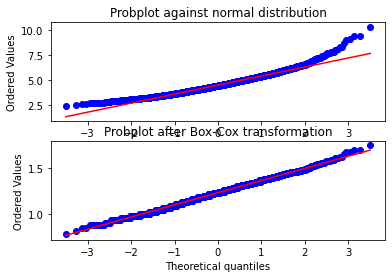

In [39]:
import scipy.stats as ss

fig = plt.figure()
ax1 = fig.add_subplot(211)
x = data[target].values
prob = ss.probplot(x, dist=ss.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, _ = ss.boxcox(x)
prob = ss.probplot(xt, dist=ss.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

In [40]:
X, y = data.drop(target, axis=1), data[target]
features = X.columns

In [41]:
train_X, val_X, train_y, val_y = train_test_split(X, np.log(y+0.0001), random_state=0, test_size=.4, shuffle=True)

In [42]:
# !pip install sklearn_pandas --user

In [43]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn_pandas import DataFrameMapper, gen_features

def map_features(features=[]):
    numerical_def = gen_features(
        columns=[[c] for c in NUMERICAL if c in features],
        classes=[
            {'class': StandardScaler}
        ]
    )

    ordinal_def = gen_features(
        columns=[[c] for c in ORDINAL if c in features],
        classes=[
            {'class': MinMaxScaler}
        ]
    )
    return numerical_def #+ ordinal_def

In [44]:
mapper1 = DataFrameMapper(map_features(features), df_out=True)

In [45]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(train, val, tr_y, val_y, features, est):
    mapper = DataFrameMapper(features, df_out=True)
#     трансформим отдельно трейн (фиттим) и тест
    train = mapper.fit_transform(train)
    val = mapper.transform(val)

    est.fit(train, tr_y)
    pred_val = est.predict(val)
    pred_train = est.predict(train)

    return pd.DataFrame({
        'train_R2': [r2_score(tr_y, pred_train)],
        'train_MAE': [mean_absolute_error(tr_y, pred_train)], 
        'train_MSE': [mean_squared_error(tr_y, pred_train)], 
        'train_MAPe': [mean_absolute_percentage_error(tr_y, pred_train)],
        'test_R2': [r2_score(val_y, pred_val)],
        'test_MAE': [mean_absolute_error(val_y, pred_val)],
        'test_MSE': [mean_squared_error(val_y, pred_val)],
        'test_MAPe': [mean_absolute_percentage_error(val_y, pred_val)]
    })

In [46]:
from sklearn.linear_model import LassoCV, RidgeCV
reg_Al2O3 = RidgeCV()
scores = evaluate_model(train_X, val_X, train_y, val_y, map_features(features), reg_Al2O3)
scores

,train_R2,train_MAE,train_MSE,train_MAPe,test_R2,test_MAE,test_MSE,test_MAPe
0,0.520956,0.101672,0.018662,6.979809,0.50475,0.103632,0.018719,7.121529


In [47]:
# from sklearn.linear_model import LassoCV, RidgeCV
# from sklearn.ensemble import RandomForestRegressor
# reg_Al2O3 = LassoCV(cv=5)#RandomForestRegressor(n_estimators=10, max_depth=5)
# scores = evaluate_model(train_X[top_features], val_X[top_features], train_y, val_y, map_features(top_features), reg_Al2O3)
# scores

In [48]:
# rf = RandomForestRegressor(max_depth=10).fit(train_X, train_y)

In [49]:
# sorted(dict(zip(train_X.columns, rf.feature_importances_)).items(), key=lambda item: item[1], reverse=True)[]

In [50]:
_ = mapper1.fit(train_X)
reg_Al2O3.fit(mapper1.transform(train_X), train_y)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [51]:
import pickle
filename = 'Al2O3.sav'
pickle.dump(reg_Al2O3, open(filename, 'wb'))

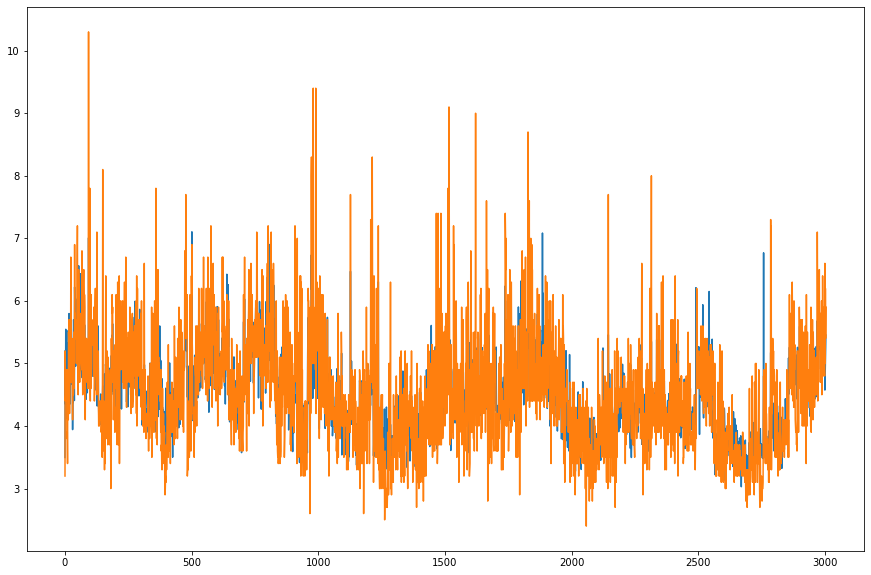

In [52]:
preds = reg_Al2O3.predict(mapper1.transform(data[features]))
fig = plt.figure(figsize=(15,10))
plt.plot(np.exp(preds))
plt.plot(data['химшлак последний Al2O3'].values)

In [53]:
# reg_Al2O3.fit(mapper.transform(train_X), train_y)

#### Следующий таргет

In [54]:
from imblearn.under_sampling import RandomUnderSampler
target = 'химшлак последний R'
data = make_train_test_for_target(df, target, set(TARGETS)) # добавим колонку Al2O3
data['химшлак последний Al2O3'] = np.exp(reg_Al2O3.predict(mapper1.transform(data[features]))) # добавим предыдущее предсказание
data = data[~(data['химшлак последний R'].isin([3.1, 1.9, 2.12, 2.9, 3.0]))]
features_2 = set(data.columns) - set([target])
NUMERICAL += ['химшлак последний Al2O3']
X, y = data[features_2], data[target]

In [55]:
from collections import Counter
Counter(data['химшлак последний R'])

Counter({2.6: 373,
         2.3: 690,
         2.5: 399,
         2.2: 907,
         2.0: 111,
         2.1: 601,
         2.4: 355,
         2.7: 342,
         2.8: 262})

In [56]:
# rus = RandomUnderSampler(random_state=232, replacement=True)# fit predictor and target variable
# x_rus, y_rus = rus.fit_resample(X, y.astype(str))
from imblearn.over_sampling import SMOTENC

ord_cols = [X.columns.get_loc(c) for c in X.columns if c in ORDINAL]
smote_nc = SMOTENC(categorical_features=ord_cols,sampling_strategy='not majority',random_state=0, k_neighbors=10)
x_rus, y_rus = smote_nc.fit_resample(X, y.astype(str))

In [57]:
Counter(y_rus)

Counter({'2.6': 907,
         '2.3': 907,
         '2.5': 907,
         '2.2': 907,
         '2.0': 907,
         '2.1': 907,
         '2.4': 907,
         '2.7': 907,
         '2.8': 907})

In [58]:
train_X, val_X, train_y, val_y = train_test_split(x_rus, y_rus.astype(float), random_state=0, test_size=.4, shuffle=True, stratify=y_rus)

In [59]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
reg_R = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=0)
# reg_R = LinearRegression()
scores = evaluate_model(train_X, val_X, train_y, val_y, map_features(features_2), reg_R)
scores

,train_R2,train_MAE,train_MSE,train_MAPe,test_R2,test_MAE,test_MSE,test_MAPe
0,0.665211,0.116723,0.022321,4.90639,0.625839,0.122838,0.024941,5.183411


In [60]:
mapper2 = DataFrameMapper(map_features(features_2), df_out=True)
_ = mapper2.fit(train_X[features_2])
reg_R.fit(mapper2.transform(train_X), train_y)

RandomForestRegressor(max_depth=5, n_estimators=10, random_state=0)

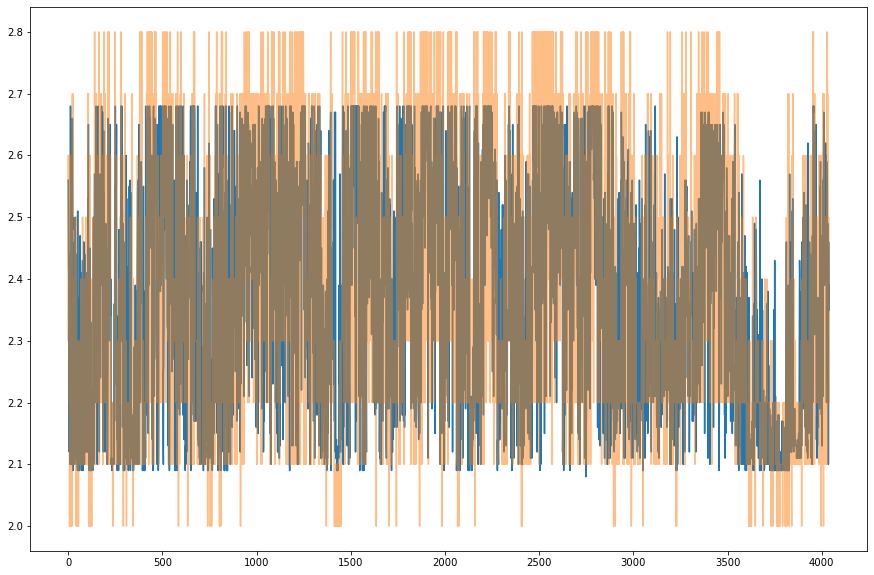

In [61]:
preds = reg_R.predict(mapper2.transform(data[features_2]))
fig = plt.figure(figsize=(15,10))
plt.plot(np.around(preds, 2))
plt.plot(data['химшлак последний R'].values, alpha=0.5)

In [62]:
mean_squared_error(data['химшлак последний R'].values, np.around(preds, 2))

0.03218680693069306

In [63]:
filename = 'R.sav'
pickle.dump(reg_R, open(filename, 'wb'))

#### Следующий таргет

<AxesSubplot:>

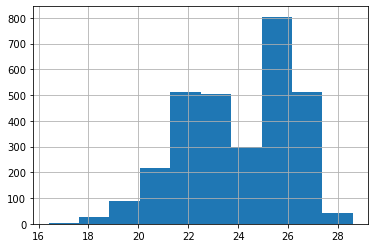

In [64]:
df['химшлак последний SiO2'].hist()

In [65]:
target = 'химшлак последний SiO2'
data = make_train_test_for_target(df, target, TARGETS)
data['химшлак последний Al2O3'] = np.exp(reg_Al2O3.predict(mapper1.transform(data[features]))) # добавим предыдущее предсказание
data['химшлак последний R'] = np.around(reg_R.predict(mapper2.transform(data[features_2])), 2) # добавим предыдущее предсказание
data['химшлак последний R_химшлак последний Al2O3_mul'] = data['химшлак последний Al2O3']*data['химшлак последний R']
features_4 = set(data.columns) - set([target])
# ORDINAL += ['химшлак последний R']
NUMERICAL += ['химшлак последний R_химшлак последний Al2O3_mul', 'химшлак последний R']
X, y = data[features_4], data[target]

In [66]:
y_strat = y.copy()
y_strat.loc[y_strat <=24] = 22
y_strat.loc[y_strat > 24] = 26

In [67]:
# train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0, test_size=.4, shuffle=True, stratify=y_strat.astype(str))
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0, test_size=.4, shuffle=True)

In [68]:
from sklearn.linear_model import LogisticRegression
# reg_SiO2 = RandomForestRegressor(n_estimators=50, max_depth=3)
reg_SiO2 = RidgeCV(cv=3)
scores = evaluate_model(train_X, val_X, train_y, val_y, map_features(features_4), reg_SiO2)
scores

,train_R2,train_MAE,train_MSE,train_MAPe,test_R2,test_MAE,test_MSE,test_MAPe
0,0.236431,1.543365,3.620202,6.619005,0.21484,1.571822,3.786306,6.726546


In [69]:
reg_SiO2.coef_

array([ 0.16302027,  0.07276782,  0.12127668,  0.18903597,  0.0661092 ,
        0.02140282, -0.28084607,  0.12458787,  0.54402163, -0.05167848,
        0.17861555, -0.1612645 ,  0.08009135, -0.01474286, -0.15805525,
       -0.08151607, -0.02883308,  0.02081718,  0.05943558,  0.02728554,
       -0.02843901,  0.06287063, -0.17692457,  0.4107873 , -0.13300413,
        0.06033875, -0.00510139,  0.12633687, -0.43529317, -0.06457429,
        0.56929134, -0.10436665, -0.17803527,  0.06890349, -0.09534266,
        0.01765971,  0.01149465,  0.09258035, -0.00784397, -0.48178899,
       -0.08879973,  0.09344886, -0.13498427, -0.08451845,  0.35152501,
        0.39864993,  0.02510515,  0.08309963,  0.0037973 ,  0.01601705,
       -0.01474289, -0.01480032, -0.23565717, -0.07061285,  0.14304932,
        0.20994022, -0.05913619,  0.07031068,  0.03836047, -0.05262716,
       -0.02047732,  0.1627884 , -0.04053009,  0.06168788,  0.06913496,
        0.23487307,  0.17759277, -0.80630131])

In [70]:
mapper4 = DataFrameMapper(map_features(features_4), df_out=True)
_ = mapper4.fit(train_X[features_4])

In [71]:
reg_SiO2.fit(mapper4.transform(train_X), train_y)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=3)

In [72]:
preds = reg_SiO2.predict(mapper4.transform(X))

In [73]:
mean_absolute_error(data['химшлак последний SiO2'].values, preds)

1.5547478176179506

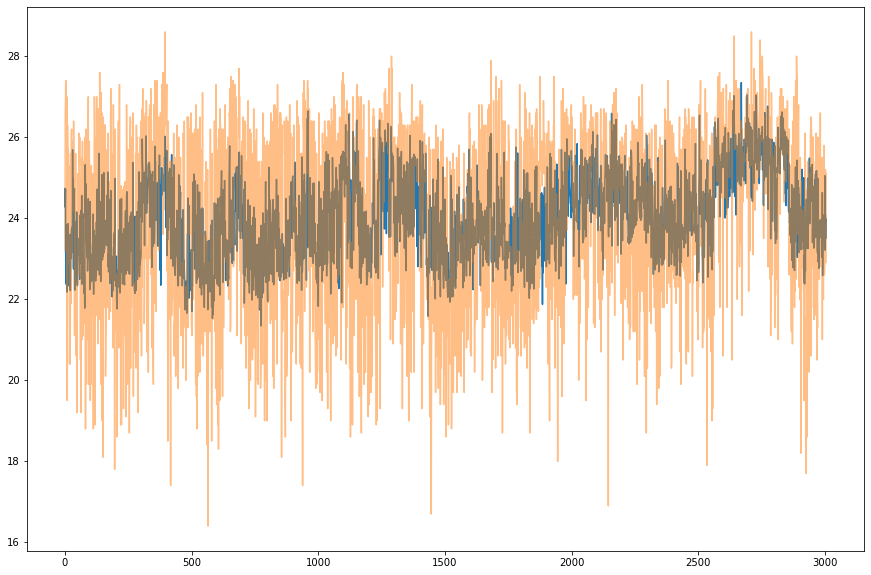

In [74]:
preds = reg_SiO2.predict(mapper4.transform(X))
fig = plt.figure(figsize=(15,10))
# plt.plot((preds-np.mean(preds))*np.std(train_y)/np.std(preds)+np.mean(preds))
plt.plot(preds)
plt.plot(data['химшлак последний SiO2'].values, alpha=0.5)

In [75]:
filename = 'SiO2.sav'
pickle.dump(reg_SiO2, open(filename, 'wb'))

#### Последний таргет

<AxesSubplot:>

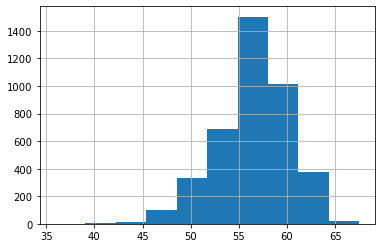

In [76]:
df['химшлак последний CaO'].hist()

In [77]:
target = 'химшлак последний CaO'
data = make_train_test_for_target(df, target, [target]) # добавим колонку Al2O3
data['химшлак последний Al2O3'] = reg_Al2O3.predict(mapper1.transform(data[features])) # добавим предыдущее предсказание
data['химшлак последний R'] = reg_R.predict(mapper2.transform(data[features_2])) # добавим предыдущее предсказание
data['химшлак последний R_химшлак последний Al2O3_mul'] = data['химшлак последний Al2O3']*data['химшлак последний R']
data['химшлак последний SiO2'] = reg_SiO2.predict(mapper4.transform(data[features_4]))
features_3 = set(data.columns) - set([target])
NUMERICAL += ['химшлак последний SiO2']
X, y = data[features_3], data[target]

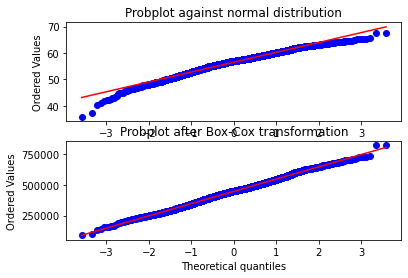

In [78]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
x = data[target].values
prob = ss.probplot(x, dist=ss.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, _ = ss.boxcox(x)
prob = ss.probplot(xt, dist=ss.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

In [79]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0, test_size=.2, shuffle=True)

In [80]:
# reg_CaO = RandomForestRegressor(n_estimators=50, max_depth=3)
reg_CaO = RidgeCV(cv=3)
scores = evaluate_model(train_X, val_X, train_y, val_y, map_features(features_3), reg_CaO)
scores

,train_R2,train_MAE,train_MSE,train_MAPe,test_R2,test_MAE,test_MSE,test_MAPe
0,0.227888,2.570239,10.940711,4.674918,0.183668,2.655558,11.42191,4.802292


In [81]:
reg_CaO.coef_

array([-0.01655957, -0.5613205 , -0.10987932,  0.2801469 ,  0.02101626,
       -0.67669553, -0.1398016 ,  0.77539056, -0.13615573,  0.11994064,
        0.04139203, -0.07088814, -0.03272765,  0.07211929, -0.04843369,
       -0.09096818,  0.09920705,  0.07973385,  0.08475049,  0.14614013,
       -0.01855727,  0.07979866, -0.51342421,  0.33118128,  0.1222807 ,
        0.24249546, -0.01203937,  0.04990858,  0.2172767 , -0.17351768,
        1.21951574,  0.04118594, -0.10727389,  0.03078194, -0.06767406,
       -0.04971107, -1.02012341, -0.05185412, -0.09114368, -0.50629046,
        0.67655189,  0.02451179, -0.538439  , -0.03008219, -0.03719278,
       -0.51217914,  0.0044036 ,  0.00956109, -0.17500601, -0.06956029,
        0.0721194 ,  0.02593101,  0.44425831,  0.09897679,  0.70327464,
       -0.17047966,  0.33347705,  0.03952757, -0.02628028, -0.26997442,
       -0.01324618,  0.23158774, -0.44067653, -0.02307696,  0.36948536,
        0.31166273, -0.08566131,  1.01640525,  0.1297238 ])

In [127]:
filename = 'CaO.sav'
pickle.dump(reg_CaO, open(filename, 'wb'))

In [92]:
len(df.columns)

69